In [120]:
#Import Client Configs
import tdAmeritradeClient
import IEXClient
import config

#Import Libs for making requests
import requests
import time
import urllib.parse as up

#Import Data Science Packages
import pandas as pd
import numpy as np
from pylab import mpl, plt

In [121]:
#Plot Formatting
plt.style.use('seaborn')

In [122]:
# Create new client

In [123]:
tdClient = tdAmeritradeClient.tdAmeritradeClient(config.td_client_id, config.url)
IEXClient = IEXClient.IEXClient(config.IEX_client_id)

In [124]:
#Utility method for converting time to epoch
pattern = '%d.%m.%Y %H:%M:%S'

def epoch(date_time):
    #date_time = '29.08.2011 11:05:02'
    epoch = int(time.mktime(time.strptime(date_time, pattern)))
    return epoch

In [125]:
def getTime(epoch):
    #epoch = 1576759500000
    #epoch = 1490157520.05
    normalTime = time.strftime(pattern, time.localtime(epoch))
    return normalTime

In [46]:
#TD Ameritrade APIs

"""
Secured
- Accounts and Trading
- Transaction History
- User Info & Preferences
- Watchlist

Unsecured
- Instruments
- Market Hours
- Movers
- Option Chains
- Price History
- Quotes
"""

'\nSecured\n- Accounts and Trading\n- Transaction History\n- User Info & Preferences\n- Watchlist\n\nUnsecured\n- Instruments\n- Market Hours\n- Movers\n- Option Chains\n- Price History\n- Quotes\n'

In [47]:
#IEX APIs

#https://iexcloud.io/docs/api/#api-reference

In [76]:
#Get Historical Data
#TODO: Get Apple Data from 2010 to 6-29-2018
endpoint = 'https://cloud.iexapis.com/stable/stock/aapl/chart/5y'

resp = IEXClient.get(endpoint)

In [77]:
type(resp)

str

In [78]:
resp

'Error Making Call. API returned 402'

In [50]:
#convert data to dataframe
dataframe = pd.DataFrame(resp)
dataframe.set_index('date',inplace=True)

In [52]:
dataframe.head()

,change,changeOverTime,changePercent,close,high,label,low,open,uClose,uHigh,uLow,uOpen,uVolume,volume
date,,,,,,,,,,,,,,
2019-12-04,0.00,0.000000,0.0000,261.74,263.31,Dec 4,260.68,261.07,261.74,263.31,260.68,261.07,16810388,16810388
2019-12-05,3.84,0.014671,1.4671,265.58,265.89,Dec 5,262.73,263.79,265.58,265.89,262.73,263.79,18661343,18661343
2019-12-06,5.13,0.034271,1.9316,270.71,271.00,Dec 6,267.30,267.48,270.71,271.00,267.30,267.48,26547493,26547493
2019-12-09,-3.79,0.019791,-1.4000,266.92,270.80,Dec 9,264.91,270.00,266.92,270.80,264.91,270.00,32182645,32182645
2019-12-10,1.56,0.025751,0.5844,268.48,270.07,Dec 10,265.86,268.60,268.48,270.07,265.86,268.60,22632383,22632383


In [51]:
stock_hist = dataframe[['open','high','low','close','volume']]

In [56]:
close = stock_hist['close'].to_numpy()

In [60]:
stock_hist = stock_hist.copy()

In [69]:
#First Strategy. Simple Moving Averages

sma1 = 3
sma2 = 5

stock_hist['sma1'] = stock_hist['close'].rolling(sma1).mean()
stock_hist['sma2'] = stock_hist['close'].rolling(sma2).mean()

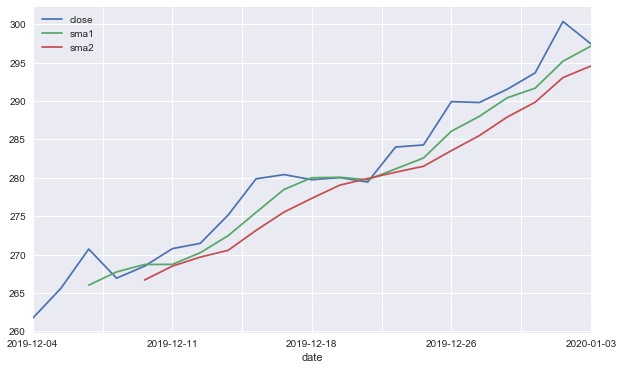

In [73]:
stock_hist.plot(y=["close","sma1","sma2"], figsize=(10, 6))

In [74]:
stock_hist['Position'] = np.where(stock_hist['sma1'] > stock_hist['sma2'], 1, -1)

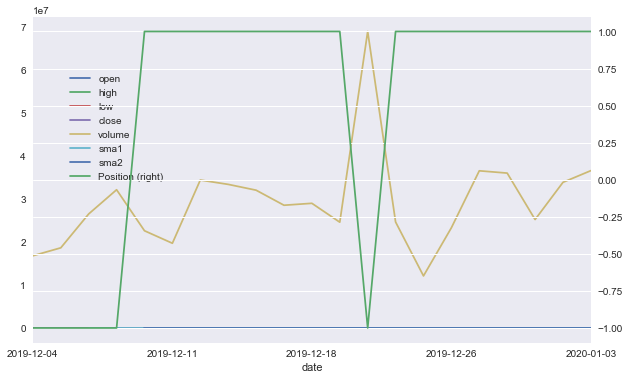

In [75]:
ax = stock_hist.plot(secondary_y='Position', figsize=(10,6))
ax.get_legend().set_bbox_to_anchor((0.25, 0.85));

In [39]:
#Get Quote Information
endpoint = 'https://cloud.iexapis.com/stable/stock/aapl/quote'

resp = IEXClient.get(endpoint)


In [23]:
resp

{'symbol': 'AAPL',
 'companyName': 'Apple, Inc.',
 'primaryExchange': 'NASDAQ',
 'calculationPrice': 'close',
 'open': 296.95,
 'openTime': 1578061800951,
 'close': 297.43,
 'closeTime': 1578085200440,
 'high': 300.58,
 'low': 296.5,
 'latestPrice': 297.43,
 'latestSource': 'Close',
 'latestTime': 'January 3, 2020',
 'latestUpdate': 1578085200440,
 'latestVolume': 36556725,
 'iexRealtimePrice': None,
 'iexRealtimeSize': None,
 'iexLastUpdated': None,
 'delayedPrice': 297.61,
 'delayedPriceTime': 1578087919131,
 'extendedPrice': 297.32,
 'extendedChange': -0.11,
 'extendedChangePercent': -0.00037,
 'extendedPriceTime': 1578099586152,
 'previousClose': 300.35,
 'previousVolume': 33911864,
 'change': -2.92,
 'changePercent': -0.00972,
 'volume': 36556725,
 'iexMarketPercent': None,
 'iexVolume': None,
 'avgTotalVolume': 27270398,
 'iexBidPrice': None,
 'iexBidSize': None,
 'iexAskPrice': None,
 'iexAskSize': None,
 'marketCap': 1321561796100,
 'peRatio': 24.92,
 'week52High': 300.6,
 'wee

In [24]:
#Make Call to get data

#define the endpoints
endpoint = "https://api.tdameritrade.com/v1/marketdata/{}/pricehistory".format('GOOG')

#define payload
body = {'periodType':'day',
       'frequencyType':'minute',
       'frequency' : '1',
       'period': '2',
       'endDate' : epoch('26.12.2019 08:00:00'),
       'startDate' : epoch('27.12.2019 17:00:00')}

content = tdClient.get(url = endpoint, body = body)

print(content)


{'candles': [{'open': 1353.1, 'high': 1353.1, 'low': 1353.1, 'close': 1353.1, 'volume': 180, 'datetime': 1576759500000}, {'open': 1353.1, 'high': 1353.1, 'low': 1353.1, 'close': 1353.1, 'volume': 294, 'datetime': 1576759860000}, {'open': 1353.1, 'high': 1353.1, 'low': 1353.1, 'close': 1353.1, 'volume': 500, 'datetime': 1576760160000}, {'open': 1352.0, 'high': 1352.0, 'low': 1352.0, 'close': 1352.0, 'volume': 100, 'datetime': 1576765680000}, {'open': 1351.82, 'high': 1355.5, 'low': 1351.0, 'close': 1355.5, 'volume': 12957, 'datetime': 1576765800000}, {'open': 1355.72, 'high': 1357.74, 'low': 1355.72, 'close': 1357.66, 'volume': 2808, 'datetime': 1576765860000}, {'open': 1357.78, 'high': 1357.94, 'low': 1357.1, 'close': 1357.8686, 'volume': 2995, 'datetime': 1576765920000}, {'open': 1358.0, 'high': 1358.1, 'low': 1357.13, 'close': 1357.13, 'volume': 4277, 'datetime': 1576765980000}, {'open': 1356.99, 'high': 1357.15, 'low': 1356.6306, 'close': 1356.6306, 'volume': 2200, 'datetime': 15767

In [25]:
df = pd.DataFrame(content.get('candles'))

In [26]:
#API Call to get movers

#The index symbol to get movers from. Can be $COMPX, $DJI, or $SPX.X. Click to edit the value.
endpoint = 'https://api.tdameritrade.com/v1/marketdata/{}/movers'.format('$DJI')

#Query Params
params = 'direction=up&change=percent'

movers = tdClient.get(url = endpoint, queryParams = params)

print(movers)


[{'change': 0.00853937046966537, 'description': 'Nike, Inc. Common Stock', 'direction': 'up', 'last': 101.57, 'symbol': 'NKE', 'totalVolume': 8454855}, {'change': 0.006947771921418339, 'description': 'Procter & Gamble Company (The) Common Stock', 'direction': 'up', 'last': 126.09, 'symbol': 'PG', 'totalVolume': 10652742}, {'change': 0.005997818974918179, 'description': 'Coca-Cola Company (The) Common Stock', 'direction': 'up', 'last': 55.35, 'symbol': 'KO', 'totalVolume': 11418983}, {'change': 0.005632802192225642, 'description': "McDonald's Corporation Common Stock", 'direction': 'up', 'last': 198.17, 'symbol': 'MCD', 'totalVolume': 4008934}, {'change': 0.0043463724506853565, 'description': 'Intel Corporation - Common Stock', 'direction': 'up', 'last': 60.08, 'symbol': 'INTC', 'totalVolume': 14086205}, {'change': 0.003915810083210997, 'description': 'Verizon Communications Inc. Common Stock', 'direction': 'up', 'last': 61.53, 'symbol': 'VZ', 'totalVolume': 17193518}, {'change': 0.0037

In [7]:
#Accessing authorization information

#auth.get('access_token')
#auth.get('refresh_token_expires_in')
#auth.get('scope')
#auth.get('expires_in')

In [12]:
#Make secured call to get accounts and account info

endpoint = "https://api.tdameritrade.com/v1/accounts"

accounts = tdClient.secureGet(endpoint)